In [1]:
import torch.nn as nn
import torch
import rawpy
import numpy as np
from torch.utils.data import DataLoader
from utils.datasets import LabeledDataset

import torchvision.transforms as transforms

import ignite.distributed as idist
from ignite.engine import Engine, Events
from ignite.contrib.handlers import ProgressBar
from ignite.metrics import FID, InceptionScore, RunningAverage

from torch.profiler import profile, record_function, ProfilerActivity

from torchinfo import summary

torch.manual_seed(9706507364633013713)

In [2]:
root_dir = "dataset"
sony_csv_files = ["dataset/Sony_train_list.txt"]
fuji_csv_files =  ["dataset/Fuji_train_list.txt"]

batch_size = 8
input_size = 512

pre_crop_transform = transforms.Compose([
    transforms.ToTensor()
])

sony_dataset = LabeledDataset(root_dir, *sony_csv_files, transform=pre_crop_transform, training=True, crop_size=input_size)
sony_dataloader = idist.auto_dataloader(sony_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True, prefetch_factor=1)
print(sony_dataset[0][0].shape)
print(sony_dataset[0][1].shape)

2023-06-12 00:24:31,501 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<utils.datasets.Labe': 
	{'batch_size': 8, 'num_workers': 8, 'shuffle': True, 'drop_last': True, 'prefetch_factor': 1, 'pin_memory': True}


torch.Size([4, 512, 512])
torch.Size([3, 1024, 1024])


In [3]:
sony_dataset.prime_buffer()

In [2]:
# from unet.unet_model import UNet
from torch import optim 
from ignite.handlers.param_scheduler import LRScheduler

class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel, kernel=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channel, out_channel, kernel_size=kernel, stride=stride, padding=padding)
        self.lrelu1_1 = nn.LeakyReLU(0.2, inplace=True)
        self.conv1_2 = nn.Conv2d(out_channel, out_channel, kernel_size=kernel, stride=stride,  padding=padding)
        self.lrelu1_2 = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x = self.conv1_1(x)
        x = self.lrelu1_1(x)
        x = self.conv1_2(x)
        x = self.lrelu1_2(x)
        return x

class ConvBlockBN(nn.Module):
    def __init__(self, in_channel, out_channel, kernel=3, stride=1, padding=1):
        super(ConvBlockBN, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channel, out_channel, kernel_size=kernel, stride=stride, padding=padding)
        self.batchnorm1_1 = nn.BatchNorm2d(out_channel)
        self.lrelu1_1 = nn.LeakyReLU(0.2, inplace=True)
        self.conv1_2 = nn.Conv2d(out_channel, out_channel, kernel_size=kernel, stride=stride,  padding=padding)
        self.batchnorm1_2 = nn.BatchNorm2d(out_channel)
        self.lrelu1_2 = nn.LeakyReLU(0.2, inplace=True)
            

    def forward(self, x):
        x = self.conv1_1(x)
        x = self.batchnorm1_1(x)
        x = self.lrelu1_1(x)
        x = self.conv1_2(x)
        x = self.batchnorm1_2(x)
        x = self.lrelu1_2(x)
        return x
    
class UpConcatBlock(nn.Module):
    def __init__(self, in_channel, out_channel, conv_block):
        super(UpConcatBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channel, in_channel // 2, kernel_size=2, stride=2)
        self.conv_block = conv_block(in_channel, out_channel)

    def forward(self, x1, x2):
        x1 = self.deconv(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = torch.nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv_block(x)

class UNet(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(UNet, self).__init__()
        
        self.down1 = ConvBlock(in_feat, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = ConvBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = ConvBlock(64, 128)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = ConvBlock(128, 256)
        self.pool4 = nn.MaxPool2d(2)
        self.down5 = ConvBlock(256, 512)

        self.up5 = UpConcatBlock(512, 256, ConvBlock)
        self.up4 = UpConcatBlock(256, 128, ConvBlock)
        self.up3 = UpConcatBlock(128, 64, ConvBlock)
        self.up2 = UpConcatBlock(64, 32, ConvBlock)

        self.conv10 = nn.Conv2d(32, out_feat, 1)

    def forward(self, x):
        down1 = self.down1(x)
        down2 = self.down2(self.pool1(down1))
        down3 = self.down3(self.pool2(down2))
        down4 = self.down4(self.pool3(down3))
        down5 = self.down5(self.pool4(down4))

        up = self.up5(down5, down4)
        up = self.up4(up, down3)
        up = self.up3(up, down2)
        up = self.up2(up, down1)

        out = self.conv10(up)
        out = torch.nn.functional.pixel_shuffle(out, 2)
        return out
    
class UNet_D(nn.Module):
    def __init__(self, in_feat):
        super(UNet_D, self).__init__()
        
        self.conv1 = nn.Conv2d(in_feat, 16, 4, 2, 1)

        self.down1 = ConvBlockBN(16, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = ConvBlockBN(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = ConvBlockBN(64, 128)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = ConvBlockBN(128, 256)
        self.pool4 = nn.MaxPool2d(2)
        self.down5 = ConvBlockBN(256, 512)
        self.pool5 = nn.MaxPool2d(2)
        self.down6 = ConvBlockBN(512, 1024)
        self.pool6 = nn.MaxPool2d(2)
        self.down7 = ConvBlockBN(1024, 2048)
        self.pool7 = nn.MaxPool2d(2)
        self.down8 = ConvBlockBN(2048, 4096)

        self.fc1 = nn.Linear(4096*4*4, 1)

        self.up8 = UpConcatBlock(4096, 2048, ConvBlockBN)
        self.up7 = UpConcatBlock(2048, 1024, ConvBlockBN)
        self.up6 = UpConcatBlock(1024, 512, ConvBlockBN)
        self.up5 = UpConcatBlock(512, 256, ConvBlockBN)
        self.up4 = UpConcatBlock(256, 128, ConvBlockBN)
        self.up3 = UpConcatBlock(128, 64, ConvBlockBN)
        self.up2 = UpConcatBlock(64, 32, ConvBlockBN)

        self.conv10 = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        x = self.conv1(x)
        down1 = self.down1(x)
        down2 = self.down2(self.pool1(down1))
        down3 = self.down3(self.pool2(down2))
        down4 = self.down4(self.pool3(down3))
        down5 = self.down5(self.pool4(down4))
        down6 = self.down6(self.pool5(down5))
        down7 = self.down7(self.pool6(down6))
        down8 = self.down8(self.pool7(down7))

        down8_ = torch.flatten(down8, 1)
        real_fake = self.fc1(down8_)

        up = self.up8(down8, down7)
        up = self.up7(up, down6)
        up = self.up6(up, down5)
        up = self.up5(up, down4)
        up = self.up4(up, down3)
        up = self.up3(up, down2)
        up = self.up2(up, down1)

        out = self.conv10(up)
        return real_fake, out

In [5]:
netG = idist.auto_model(UNet(4, 12))
netD = idist.auto_model(UNet_D(3))
optimizerG = idist.auto_optim(optim.Adam(netG.parameters(), lr=1e-4, betas=(0.5, 0.999)))
optimizerD = idist.auto_optim(optim.Adam(netD.parameters(), lr=1e-4, betas=(0.5, 0.999)))
loss = nn.L1Loss()
criterion = nn.BCEWithLogitsLoss()
lr_scheduler = LRScheduler(optim.lr_scheduler.StepLR(optimizerG, step_size=10, gamma=0.8))

2023-06-12 00:25:33,245 ignite.distributed.auto.auto_model INFO: Apply torch DataParallel on model
2023-06-12 00:25:35,813 ignite.distributed.auto.auto_model INFO: Apply torch DataParallel on model


In [6]:
input_data = torch.randn(batch_size, 4, input_size, input_size)
summary(netG, input_data = input_data)

Layer (type:depth-idx)                   Output Shape              Param #
DataParallel                             [8, 3, 1024, 1024]        --
├─UNet: 1-1                              [4, 3, 1024, 1024]        7,760,748
├─UNet: 1-4                              --                        (recursive)
│    └─ConvBlock: 2-1                    [4, 32, 512, 512]         10,432
│    └─ConvBlock: 2-26                   --                        (recursive)
│    │    └─Conv2d: 3-1                  [4, 32, 512, 512]         1,184
├─UNet: 1-3                              [4, 3, 1024, 1024]        --
├─UNet: 1-4                              --                        (recursive)
│    └─ConvBlock: 2-3                    [4, 32, 512, 512]         --
│    └─ConvBlock: 2-26                   --                        (recursive)
│    │    └─Conv2d: 3-2                  [4, 32, 512, 512]         --
│    │    └─LeakyReLU: 3-3               [4, 32, 512, 512]         --
│    │    └─Conv2d: 3-4            

In [7]:
input_data = torch.randn(batch_size, 3, input_size*2, input_size*2)
summary(netD, input_data = input_data)

Layer (type:depth-idx)                   Output Shape              Param #
DataParallel                             [8, 1]                    --
├─UNet_D: 1-1                            [4, 1]                    497,851,282
├─UNet_D: 1-4                            --                        (recursive)
│    └─Conv2d: 2-1                       [4, 16, 512, 512]         784
├─UNet_D: 1-3                            [4, 1]                    --
├─UNet_D: 1-4                            --                        (recursive)
│    └─Conv2d: 2-2                       [4, 16, 512, 512]         --
│    └─ConvBlockBN: 2-3                  [4, 32, 512, 512]         14,016
│    └─ConvBlockBN: 2-8                  --                        (recursive)
│    │    └─Conv2d: 3-1                  [4, 32, 512, 512]         4,640
│    └─ConvBlockBN: 2-5                  [4, 32, 512, 512]         --
│    └─ConvBlockBN: 2-8                  --                        (recursive)
│    │    └─Conv2d: 3-2         

In [8]:
def random_crop(image_short, image_long, size):
    H = image_short.shape[2]
    W = image_short.shape[3]
    ps = size
    xx = np.random.randint(0, W - ps)
    yy = np.random.randint(0, H - ps)
    image_short = image_short[:,:,yy:yy + ps, xx:xx + ps]
    image_long = image_long[:,:,yy * 2:yy * 2 + ps * 2, xx * 2:xx * 2 + ps * 2]
    return image_short, image_long

def pack_sony_raw(batch, device=None):
    if not device:
        device = idist.device()
    batch = torch.maximum(batch - 512, torch.Tensor([0]).to(device=device)) / (16383 - 512)
    H = batch.shape[2]
    W = batch.shape[3]

    out = torch.cat((batch[:,:, 0:H:2, 0:W:2], 
                     batch[:,:, 0:H:2, 1:W:2],
                     batch[:,:, 1:H:2, 1:W:2],
                     batch[:,:, 1:H:2, 0:W:2]), dim=1)
    return out

In [9]:
real_label = 1
fake_label = 0

def training_step(engine, batch):
    netG.train()
    netD.train()

    short, long, ratio, cam_model, exposure_ratio, _, _= batch

    short = short.to(idist.device())
    long = long.to(idist.device())

    # short = pack_sony_raw(short)

    long = long / 65535.0
    short = short * exposure_ratio.float().to(idist.device()).view(-1, 1, 1, 1)
    # short, long = random_crop(short, long, input_size)

    # Train Discriminator with ground truth data
    netD.zero_grad()
    b_size = long.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=idist.device())

    D_real_enc_out, D_real_dec_out = netD(long)
    D_real_enc_out = D_real_enc_out.view(-1)
    errD_real_enc = criterion(D_real_enc_out, label)
    errD_real_dec = criterion(D_real_dec_out, label.view(-1, 1, 1, 1).expand_as(D_real_dec_out))
    errD_real = errD_real_enc + errD_real_dec
    errD_real.backward()

    # Train with all-fake batch
    fake = netG(short)
    label.fill_(fake_label)

    D_fake_enc_out, D_fake_dec_out = netD(fake.detach())
    D_fake_enc_out = D_fake_enc_out.view(-1)
    errD_fake_enc = criterion(D_fake_enc_out, label)
    errD_fake_dec = criterion(D_fake_dec_out, label.view(-1, 1, 1, 1).expand_as(D_fake_dec_out))
    errD_fake = errD_fake_enc + errD_fake_dec
    errD_fake.backward()

    errD = errD_real + errD_fake
    optimizerD.step()

    # Train G
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost

    G_D_enc_out, G_D_dec_out = netD(fake)
    
    errG_l1 = loss(fake, long)
    errG_dec = criterion(G_D_dec_out, label.view(-1, 1, 1, 1).expand_as(G_D_dec_out))
    errG = 0.999*errG_l1 + 0.001*errG_dec   # Target loss: 0.02, errG_dec (10%) at ~3 => 0.001*3
    errG.backward()

    optimizerG.step()

    return {
        "Loss_G" : errG.item(),
        "Loss_D" : errD.item(),
        "D_real_enc": errD_real_enc.mean().item(),
        "D_real_dec": errD_real_dec.mean().item(),
        "D_fake_enc": errD_fake_enc.mean().item(),
        "D_fake_dec": errD_fake_dec.mean().item(),
        "D_G_L1": errG_l1.item(),
        "D_G_dec": errG_dec.mean().item(),
    }

In [10]:
trainer = Engine(training_step)
trainer.add_event_handler(Events.EPOCH_STARTED, lr_scheduler)
losses_key = ["Loss_G","Loss_D","D_real_enc","D_real_dec","D_fake_enc","D_fake_dec","D_G_L1","D_G_dec"]
losses = {}
for k in losses_key:
    losses[k] = []

RunningAverage(output_transform=lambda x: x["Loss_G"]).attach(trainer, "Loss_G")
RunningAverage(output_transform=lambda x: x["Loss_D"]).attach(trainer, "Loss_D")  
RunningAverage(output_transform=lambda x: x["D_real_enc"]).attach(trainer, "D_real_enc")  
RunningAverage(output_transform=lambda x: x["D_real_dec"]).attach(trainer, "D_real_dec")  
RunningAverage(output_transform=lambda x: x["D_fake_enc"]).attach(trainer, "D_fake_enc")  
RunningAverage(output_transform=lambda x: x["D_fake_dec"]).attach(trainer, "D_fake_dec")  
RunningAverage(output_transform=lambda x: x["D_G_L1"]).attach(trainer, "D_G_L1")  
RunningAverage(output_transform=lambda x: x["D_G_dec"]).attach(trainer, "D_G_dec")  
ProgressBar().attach(trainer, metric_names=["Loss_G","Loss_D","D_real_enc","D_real_dec","D_fake_enc","D_fake_dec","D_G_L1","D_G_dec"])

@trainer.on(Events.EPOCH_COMPLETED)
def store_losses(engine):
    o = engine.state.output
    print(o["D_G_L1"])
    for k in losses_key:
        losses[k].append(o[k])

best_l1 = 9999
@trainer.on(Events.EPOCH_COMPLETED)
def save_checkpoint(engine):
    global best_l1
    if engine.state.output["D_G_L1"] < best_l1:
        best_l1 = engine.state.output["D_G_L1"]

        torch.save({
            'epoch': engine.state.epoch,
            'model_state_dict': netG.state_dict(),
            'optimizer_state_dict': optimizerG.state_dict(),
            'loss': criterion,
            'l1loss': loss,
            'modelD_state_dict': netD.state_dict(),
            'optimizerD_state_dict': optimizerD.state_dict(),
            }, 'model_best.pt')

/home/pikachu/.local/lib/python3.10/site-packages/ignite/contrib/handlers/tqdm_logger.py:127: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [11]:
num_epoch = 100
def training(*args):
    trainer.run(sony_dataloader, max_epochs=num_epoch)

with idist.Parallel(backend='nccl') as parallel:
    parallel.run(training)

2023-06-12 00:25:39,672 ignite.distributed.launcher.Parallel INFO: Initialized processing group with backend: 'nccl'
2023-06-12 00:25:39,673 ignite.distributed.launcher.Parallel INFO: - Run '<function training at 0x7f6927f12560>' in 1 processes


0.09745856374502182


0.06880583614110947


0.04088626056909561


0.06556326150894165


0.054947759956121445


0.06281029433012009


0.06265170127153397


0.061913829296827316


0.07148998975753784


0.06496509164571762


0.048162803053855896


0.06316465139389038


0.05682637542486191


0.05599486827850342


0.041797488927841187


0.03673967719078064


0.04234960302710533


0.03579561412334442


0.06097021698951721


0.045274049043655396


0.04399319738149643


0.047837406396865845


0.03651760518550873


0.04730804264545441


0.051311563700437546


0.060240596532821655


0.037842877209186554


0.037684887647628784


0.03940541297197342


0.03376512601971626


0.03418012335896492


0.03277309238910675


0.0589158833026886


0.03669847548007965


0.03960462659597397


0.044544197618961334


0.034368764609098434


0.04426626116037369


0.041599955409765244


0.03672216832637787


0.03832031413912773


0.041670724749565125


0.03783763200044632


0.036357581615448


0.03361579403281212


0.04863857477903366


0.03875181823968887


0.04276365786790848


0.035170771181583405


0.04094495251774788


0.04122118651866913


0.03401460126042366


0.027065511792898178


0.02884032391011715


0.03268367424607277


0.03555668890476227


0.04071658104658127


0.03203188627958298


0.03314238041639328


0.04587420076131821


0.037876520305871964


0.02757793292403221


0.034585487097501755


0.03999392315745354


0.032039470970630646


0.03142654150724411


0.021708205342292786


0.03576665744185448


0.04077562689781189


0.02672787383198738


0.03654345124959946


0.04503336176276207


0.03270114213228226


0.03403933718800545


0.03791021183133125


0.039388105273246765


0.02796088717877865


0.03829203546047211


0.03592531383037567


0.036858320236206055


0.04176253080368042


0.025833770632743835


0.03284132108092308


0.03408905863761902


0.02809087000787258


0.028402715921401978


0.03770129382610321


0.03308321163058281


0.03657498583197594


0.025885945186018944


0.03417808935046196


0.04288380593061447


0.032383911311626434


0.030704757198691368


0.04102589935064316


0.028174420818686485


0.03140971437096596


0.030576299875974655


0.029574988409876823


0.04104942828416824


2023-06-12 19:08:06,205 ignite.distributed.launcher.Parallel INFO: End of run
2023-06-12 19:08:06,206 ignite.distributed.launcher.Parallel INFO: Finalized processing group with backend: 'nccl'


In [12]:
torch.save({
            'epoch': num_epoch,
            'model_state_dict': netG.state_dict(),
            'optimizer_state_dict': optimizerG.state_dict(),
            'loss': criterion,
            'modelD_state_dict': netD.state_dict(),
            'optimizerD_state_dict': optimizerD.state_dict(),
            }, 'model_seed_{}.pt'.format(torch.random.initial_seed()))

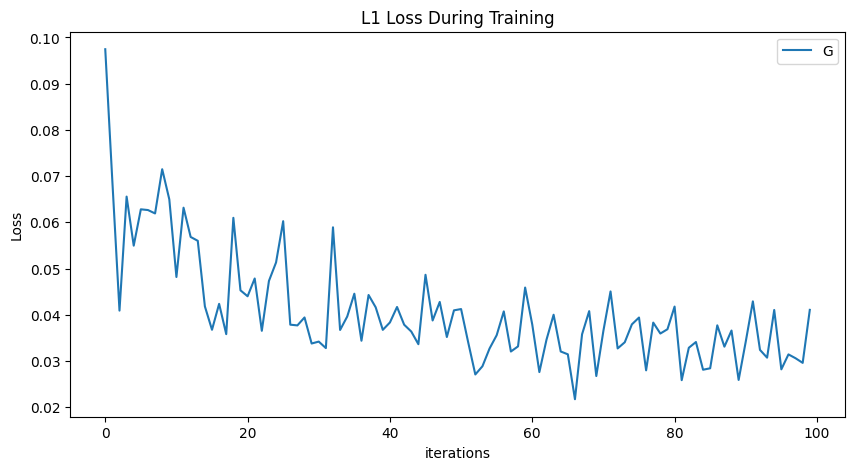

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5))
plt.title("L1 Loss During Training")
plt.plot(losses['D_G_L1'],label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

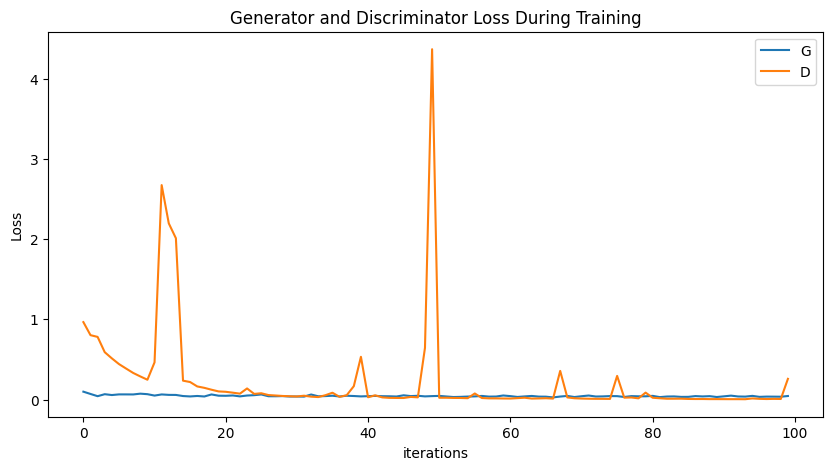

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(losses['Loss_G'],label="G")
plt.plot(losses['Loss_D'],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

In [4]:
import cv2

# Load best model
checkpoint = torch.load('model_best.pt')
# checkpoint = torch.load('model_seed_{}.pt'.format(torch.random.initial_seed()))
best_model = idist.auto_model(UNet(4, 12))

best_model.load_state_dict(checkpoint['model_state_dict'])
print(checkpoint['epoch'])


2023-06-12 23:27:59,809 ignite.distributed.auto.auto_model INFO: Apply torch DataParallel on model


100


In [ ]:
root_dir = "dataset"
sony_test_csv_files = ["dataset/Sony_test_list.txt"]

sony_test_dataset = LabeledDataset(root_dir, *sony_test_csv_files, training=False, transform=transforms.Compose([
    transforms.ToTensor()
]))
sony_test_dataloader = DataLoader(sony_test_dataset, batch_size=1, num_workers=1)

tensor(9.9451e-05, device='cuda:0') tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0')
tensor(0.0249, device='cuda:0') tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(250., device='cuda:0')
0.16856164 0.1304174 0.0 1.0
0.1579288 0.12947181 0.0 1.0
0.117507786 0.089067526 0.0 1.0
0.1745267 0.13415731 0.0 1.0
0.15320197 0.12263676 0.0 1.0
0.11769672 0.09105058 0.0 1.0


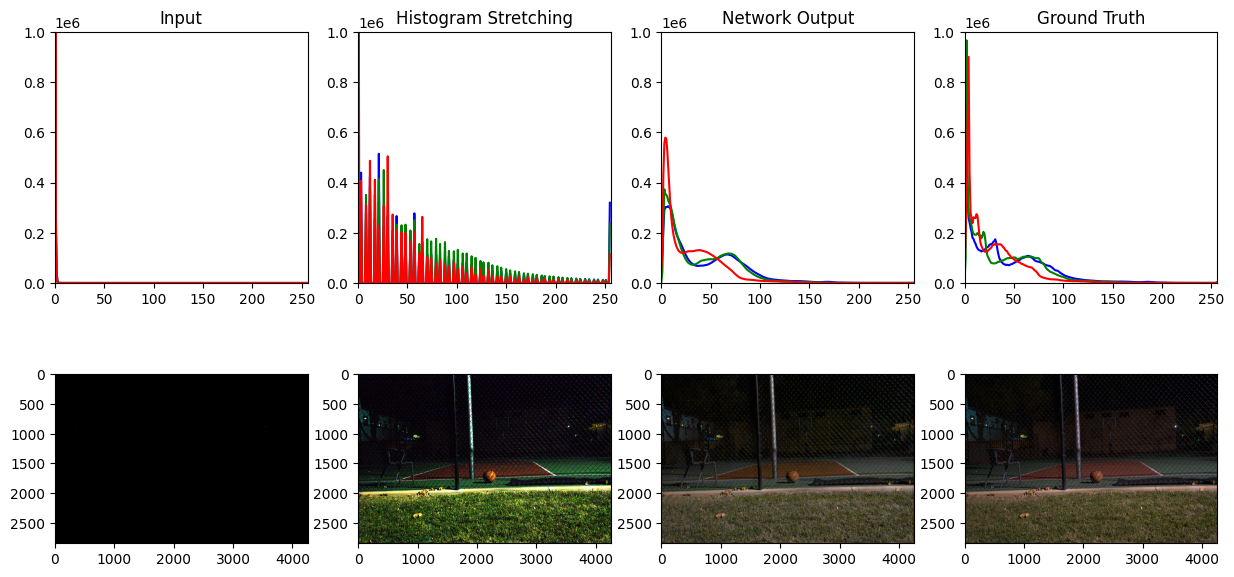

tensor(0.0003, device='cuda:0') tensor(0.0001, device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0')
tensor(0.0300, device='cuda:0') tensor(0.0126, device='cuda:0') tensor(0., device='cuda:0') tensor(100., device='cuda:0')
0.1587145 0.11144283 0.0 1.0
0.15719035 0.1320001 0.0 1.0
0.11347312 0.08479974 0.0 1.0
0.1745267 0.13415731 0.0 1.0
0.15320197 0.12263676 0.0 1.0
0.11769672 0.09105058 0.0 1.0


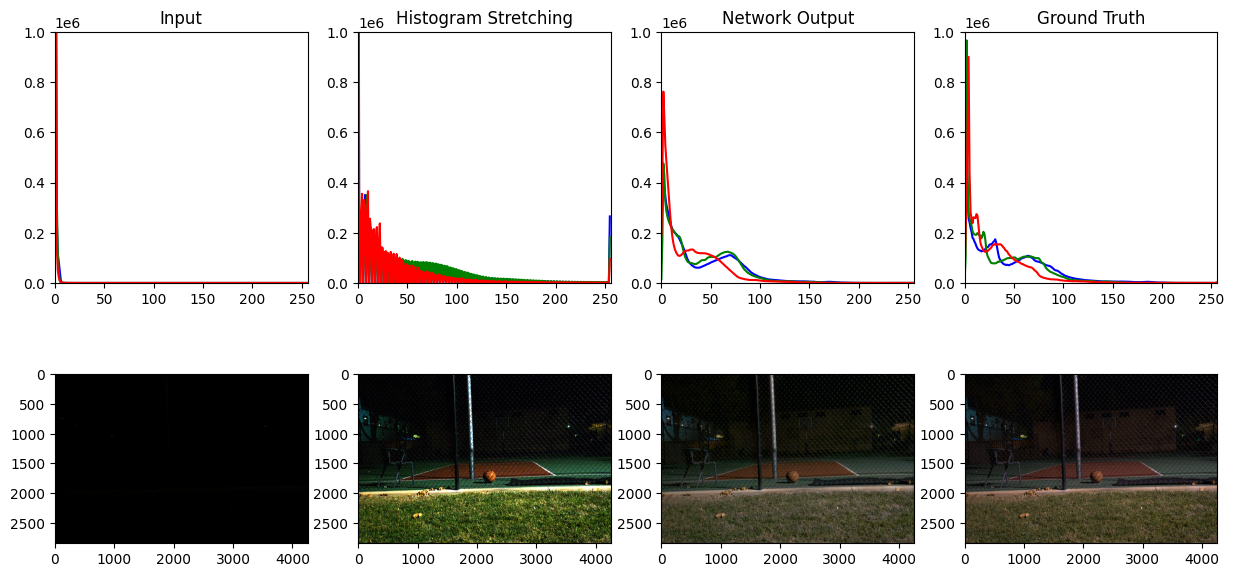

tensor(0.0001, device='cuda:0') tensor(6.3008e-05, device='cuda:0') tensor(0., device='cuda:0') tensor(0.0129, device='cuda:0')
tensor(0.0317, device='cuda:0') tensor(0.0158, device='cuda:0') tensor(0., device='cuda:0') tensor(3.2134, device='cuda:0')
0.17532164 0.17371193 0.0 0.99041164
0.14865838 0.14041525 0.0 0.9447152
0.1256363 0.11530185 0.0 0.82716036
0.16390072 0.16130312 0.0 1.0
0.13471788 0.12680247 0.0 1.0
0.13667648 0.1257496 0.0 1.0


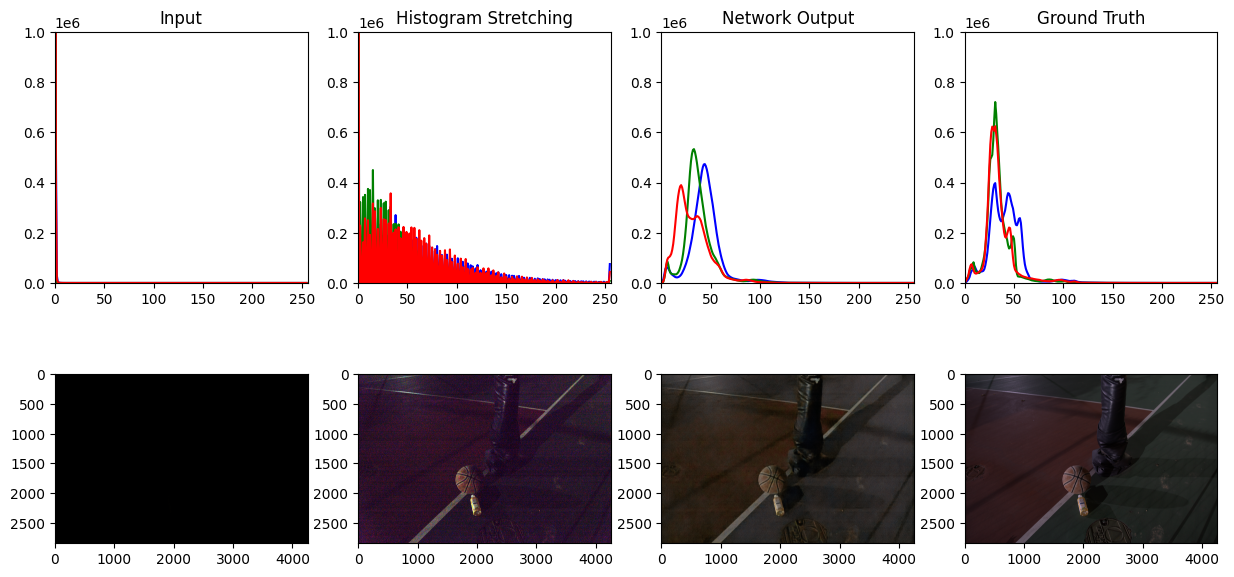

tensor(8.3668e-05, device='cuda:0') tensor(6.3008e-05, device='cuda:0') tensor(0., device='cuda:0') tensor(0.1387, device='cuda:0')
tensor(0.0209, device='cuda:0') tensor(0.0158, device='cuda:0') tensor(0., device='cuda:0') tensor(34.6702, device='cuda:0')
0.13984087 0.12392883 0.0 1.0
0.1362675 0.1240603 0.0 1.0
0.12172219 0.12194286 0.0 1.0
0.1526067 0.1371023 0.0 1.0
0.13751055 0.12762646 0.0 1.0
0.11115194 0.11282521 0.0 1.0


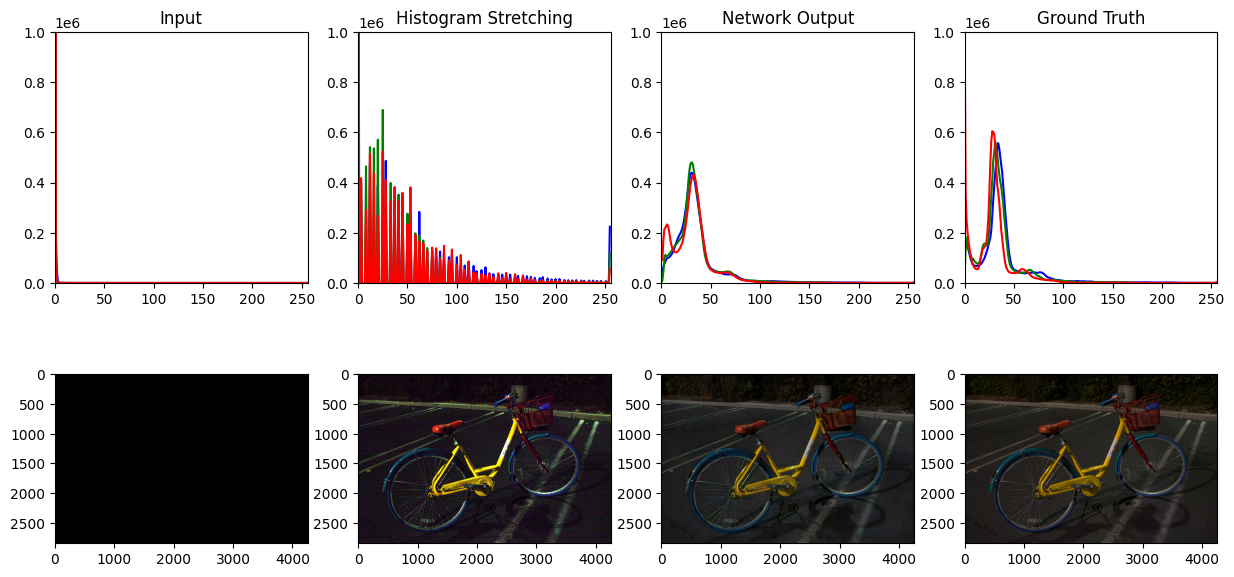

tensor(9.3496e-05, device='cuda:0') tensor(6.3008e-05, device='cuda:0') tensor(0., device='cuda:0') tensor(0.0594, device='cuda:0')
tensor(0.0234, device='cuda:0') tensor(0.0158, device='cuda:0') tensor(0., device='cuda:0') tensor(14.8384, device='cuda:0')
0.18333593 0.163905 0.0 1.0
0.13305102 0.11083532 0.0 1.0
0.077747025 0.054939322 0.0 1.0
0.17585072 0.16221866 0.0 1.0
0.12842868 0.10785077 0.0 1.0
0.07044467 0.047241934 0.0 1.0


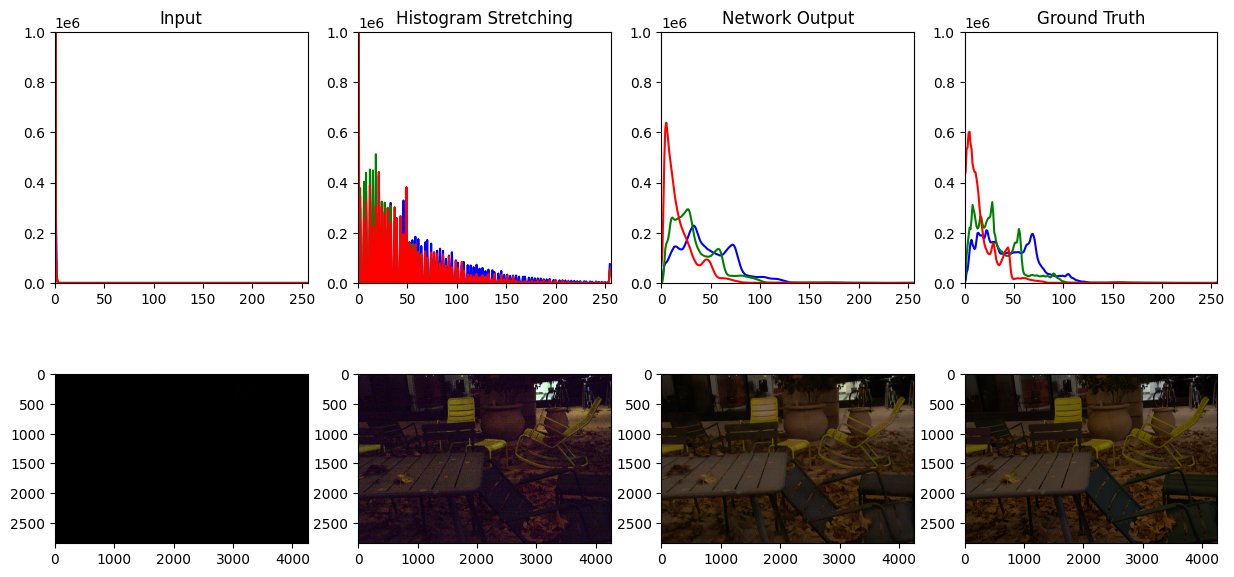

tensor(0.0002, device='cuda:0') tensor(0.0001, device='cuda:0') tensor(0., device='cuda:0') tensor(0.1466, device='cuda:0')
tensor(0.0224, device='cuda:0') tensor(0.0126, device='cuda:0') tensor(0., device='cuda:0') tensor(14.6620, device='cuda:0')
0.17760123 0.15841225 0.0 1.0
0.13216057 0.10898072 0.0 1.0
0.072598755 0.05324728 0.0 1.0
0.17585072 0.16221866 0.0 1.0
0.12842868 0.10785077 0.0 1.0
0.07044467 0.047241934 0.0 1.0


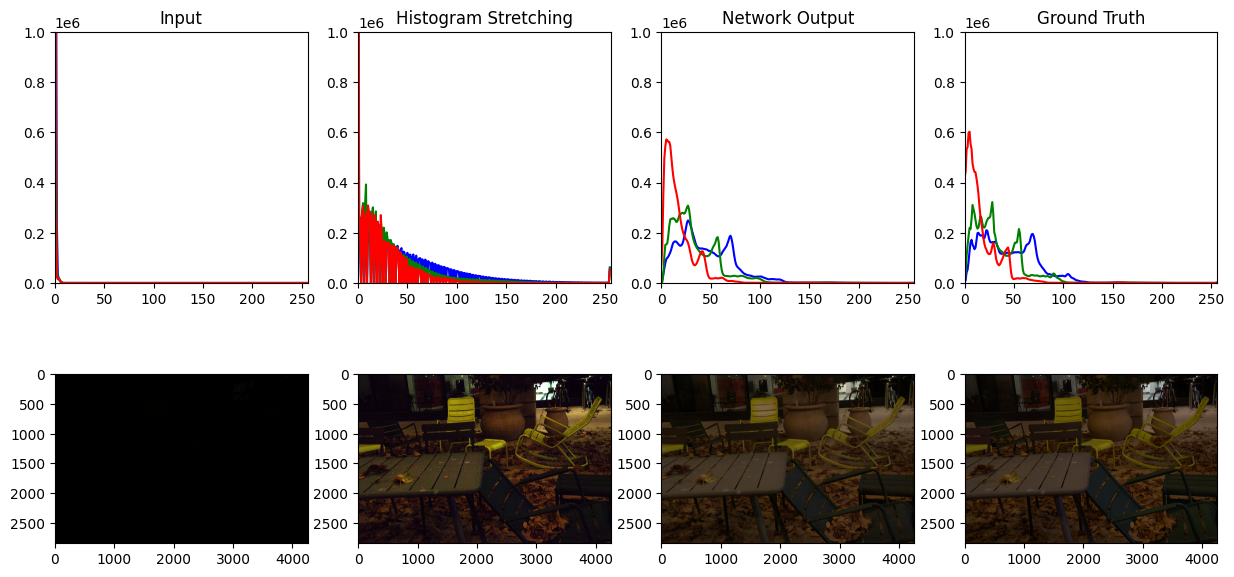

tensor(0.0011, device='cuda:0') tensor(0.0008, device='cuda:0') tensor(0., device='cuda:0') tensor(0.7309, device='cuda:0')
tensor(0.1149, device='cuda:0') tensor(0.0756, device='cuda:0') tensor(0., device='cuda:0') tensor(73.0893, device='cuda:0')
0.45697477 0.45534316 0.0080374405 0.97469276
0.36531353 0.36722746 0.0027328655 1.0
0.2324643 0.20337519 0.0 0.93854845
0.45840585 0.45607692 0.0 1.0
0.36945933 0.37097734 0.004806592 1.0
0.22926527 0.18481727 0.0 1.0


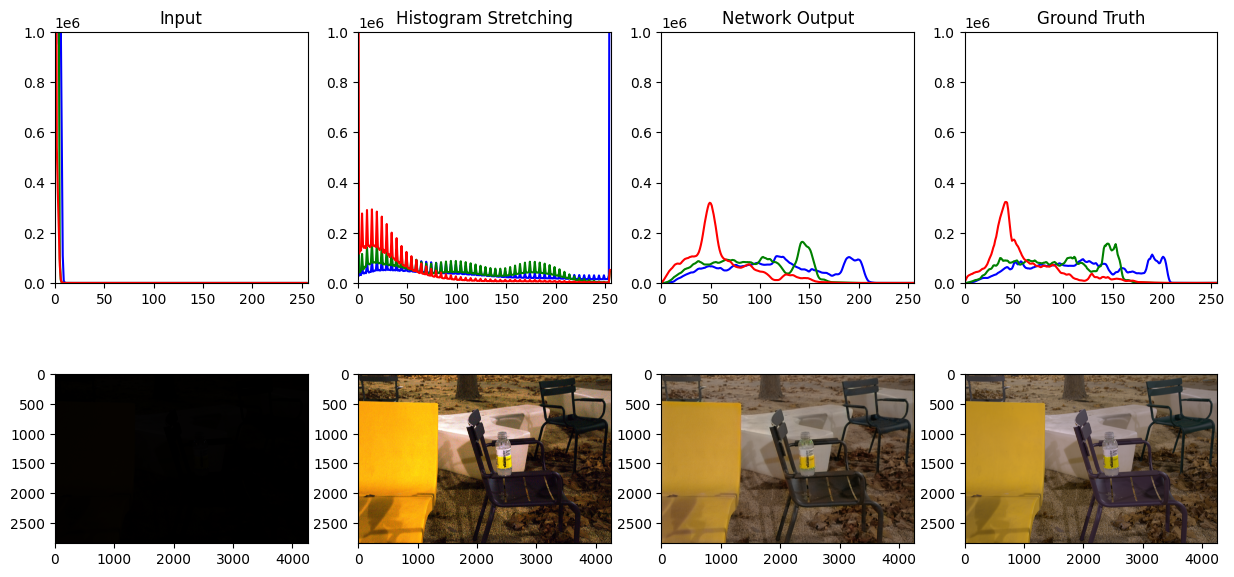

In [18]:
import matplotlib.pyplot as plt

with torch.no_grad():
    best_model.eval()
    list_samp = [1, 13, 27, 39, 51, 61, 73]
    o = 0
    for batch in sony_test_dataloader:
    # batch = next(iter(sony_test_dataloader))
        short, long, ratio, cam_model, exposure_ratio, _, _, short_raw = batch
        o += 1
        if o > list_samp[-1]:
            break
        if o not in list_samp:
            continue
        short_ = short
        short = short.to(idist.device())
        long = long.to(idist.device())

        short = pack_sony_raw(short)
        print(torch.mean(short), torch.median(short), torch.min(short), torch.max(short))
        long = long / 65535.0
        short = short * exposure_ratio.float().to(idist.device()).view(-1, 1, 1, 1)
        print(torch.mean(short), torch.median(short), torch.min(short), torch.max(short))
        
        
        output = best_model(short)
        # output = torch.nn.functional.pixel_shuffle(output, 2)

        output = output[0, :, :, :].to('cpu').numpy()
        output = np.minimum(np.maximum(output, 0), 1)
        gt_full = long[0, :, :, :].to('cpu').numpy()
        raw_input = short_raw[0, :, :, :].to('cpu').numpy() / 65535.0
        scale_full = np.float32(short_raw[0, :, :, :].to('cpu').numpy() / 65535.0)
        scale_full = scale_full * np.mean(gt_full) / np.mean(scale_full) 

        print(np.mean(output[0]), np.median(output[0]), np.min(output[0]), np.max(output[0]))
        print(np.mean(output[1]), np.median(output[1]), np.min(output[1]), np.max(output[1]))
        print(np.mean(output[2]), np.median(output[2]), np.min(output[2]), np.max(output[2]))
        print(np.mean(gt_full[0]), np.median(gt_full[0]), np.min(gt_full[0]), np.max(gt_full[0]))
        print(np.mean(gt_full[1]), np.median(gt_full[1]), np.min(gt_full[1]), np.max(gt_full[1]))
        print(np.mean(gt_full[2]), np.median(gt_full[2]), np.min(gt_full[2]), np.max(gt_full[2]))

        output = np.minimum(np.transpose(output, (1,2,0)) * 255, 255).astype(np.uint8)
        # output = (output-np.min(output))/(np.max(output)-np.min(output))
        gt_full = np.minimum(np.transpose(gt_full, (1,2,0)) * 255, 255).astype(np.uint8)
        raw_input = np.minimum(raw_input * 255, 255).astype(np.uint8)
        scale_full = np.minimum(scale_full * 255, 255).astype(np.uint8)

        color = ('b','g','r')
        plt.figure(figsize=(15,15))
        ax = plt.subplot(4,4,1)
        ax.set_title("Input")
        ax.set_ylim([0, 1e6])
        for i,col in enumerate(color):
            histr = cv2.calcHist([raw_input],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.subplot(4,4,5)
        plt.imshow(raw_input)

        ax = plt.subplot(4,4,2)
        ax.set_title("Histogram Stretching")
        ax.set_ylim([0, 1e6])
        for i,col in enumerate(color):
            histr = cv2.calcHist([scale_full],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.subplot(4,4,6)
        plt.imshow(scale_full)

        ax = plt.subplot(4,4,3)
        ax.set_title("Network Output")
        ax.set_ylim([0, 1e6])
        for i,col in enumerate(color):
            histr = cv2.calcHist([output],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.subplot(4,4,7)
        plt.imshow(output)

        ax = plt.subplot(4,4,4)
        ax.set_title("Ground Truth")
        ax.set_ylim([0, 1e6])
        for i,col in enumerate(color):
            histr = cv2.calcHist([gt_full],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.subplot(4,4,8)
        plt.imshow(gt_full)
        plt.show()

In [19]:
print(losses)

{'Loss_G': [0.09857788681983948, 0.0701061561703682, 0.04230600595474243, 0.06713501363992691, 0.05663798004388809, 0.06464479118585587, 0.0646044984459877, 0.06401660293340683, 0.07371621578931808, 0.06734389811754227, 0.04990946128964424, 0.06405271589756012, 0.05860713869333267, 0.057955171912908554, 0.044136591255664825, 0.03918193280696869, 0.04498055577278137, 0.03865496814250946, 0.06395997852087021, 0.048483096063137054, 0.047297846525907516, 0.05123433470726013, 0.039961013942956924, 0.05059519037604332, 0.05484211444854736, 0.0637388676404953, 0.04160929471254349, 0.041518088430166245, 0.04340241104364395, 0.0379653126001358, 0.03824129328131676, 0.0367811843752861, 0.06316479295492172, 0.0410255566239357, 0.04347098991274834, 0.04809121787548065, 0.0386074036359787, 0.04797159507870674, 0.04444144293665886, 0.039718374609947205, 0.04272131621837616, 0.045848675072193146, 0.04216912388801575, 0.041026659309864044, 0.038372982293367386, 0.05345742776989937, 0.04346458986401558

In [5]:
from ignite.metrics import PSNR, SSIM

def eval_step(engine, batch):
    short, long, ratio, cam_model, exposure_ratio, _, _, short_raw = batch

    short = short.to(idist.device())
    long = long.to(idist.device())

    short = pack_sony_raw(short)
    long = long / 65535.0
    short = short * exposure_ratio.float().to(idist.device()).view(-1, 1, 1, 1)   
    
    output = best_model(short)
    output = torch.minimum(torch.maximum(output, torch.Tensor([0]).to(idist.device())), torch.Tensor([1]).to(idist.device()))

    return output, long

evaluator = Engine(eval_step)
psnr = PSNR(data_range=1.0)
psnr.attach(evaluator, 'psnr')
ssim = SSIM(data_range=1.0)
ssim.attach(evaluator, 'ssim')
ProgressBar().attach(evaluator)

/home/pikachu/.local/lib/python3.10/site-packages/ignite/contrib/handlers/tqdm_logger.py:127: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [6]:
root_dir = "dataset"
sony_val_csv_files = ["dataset/Sony_test_list.txt"]

sony_val_dataset = LabeledDataset(root_dir, *sony_val_csv_files, training=False, transform=transforms.Compose([
    transforms.ToTensor()
]))
sony_val_dataloader = idist.auto_dataloader(sony_val_dataset, batch_size=2, num_workers=8)

2023-06-12 23:28:32,111 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<utils.datasets.Labe': 
	{'batch_size': 2, 'num_workers': 8, 'pin_memory': True}


In [10]:
state = evaluator.run(sony_val_dataloader)

In [11]:
print(state.metrics['psnr'])
print(state.metrics['ssim'])

27.178163931415128
0.7473750756896331
